In [34]:
!ls ~/data/mnist
import numpy as np 
from model import VAE
import torch
import torch.nn.functional as F
import utils
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.signal import medfilt
import utils
%matplotlib inline
%load_ext autoreload
%autoreload 2


mnist.npz  mnist-numpy.zip
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu" 
datapath = "/home/umang/data/mnist/mnist.npz"
data = np.load(datapath)
X, X_test = data['x_train'], data['x_test']

N = X.shape[0]
X = X.reshape(N, -1)
X = torch.tensor(X, device=device).float()/256
X_test = torch.tensor(X_test,device=device).float()/256

In [36]:
n_epoch = 50
z_size = 16
batch_size = 64
lr  = 1e-3

model = VAE(z_size).to(device)
print(model)
optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=784, bias=True)
  )
  (loss_fn): MSELoss()
)


49


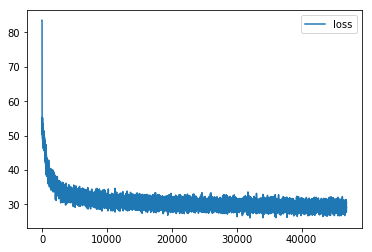

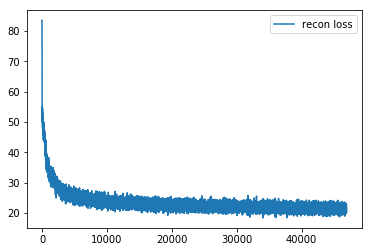

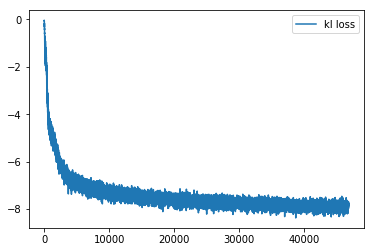

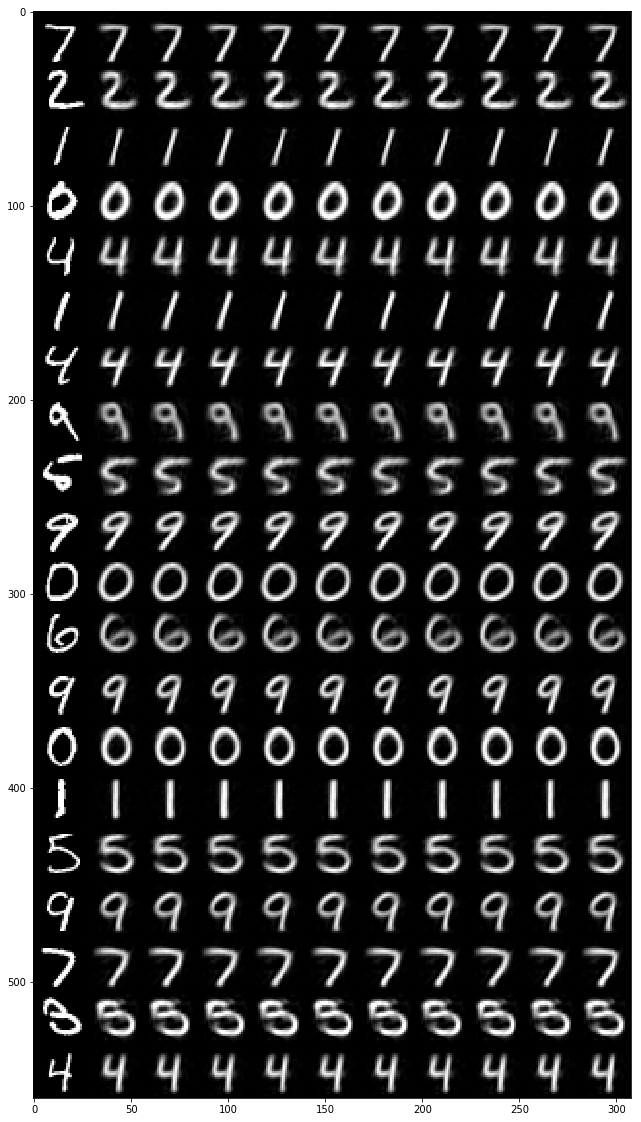

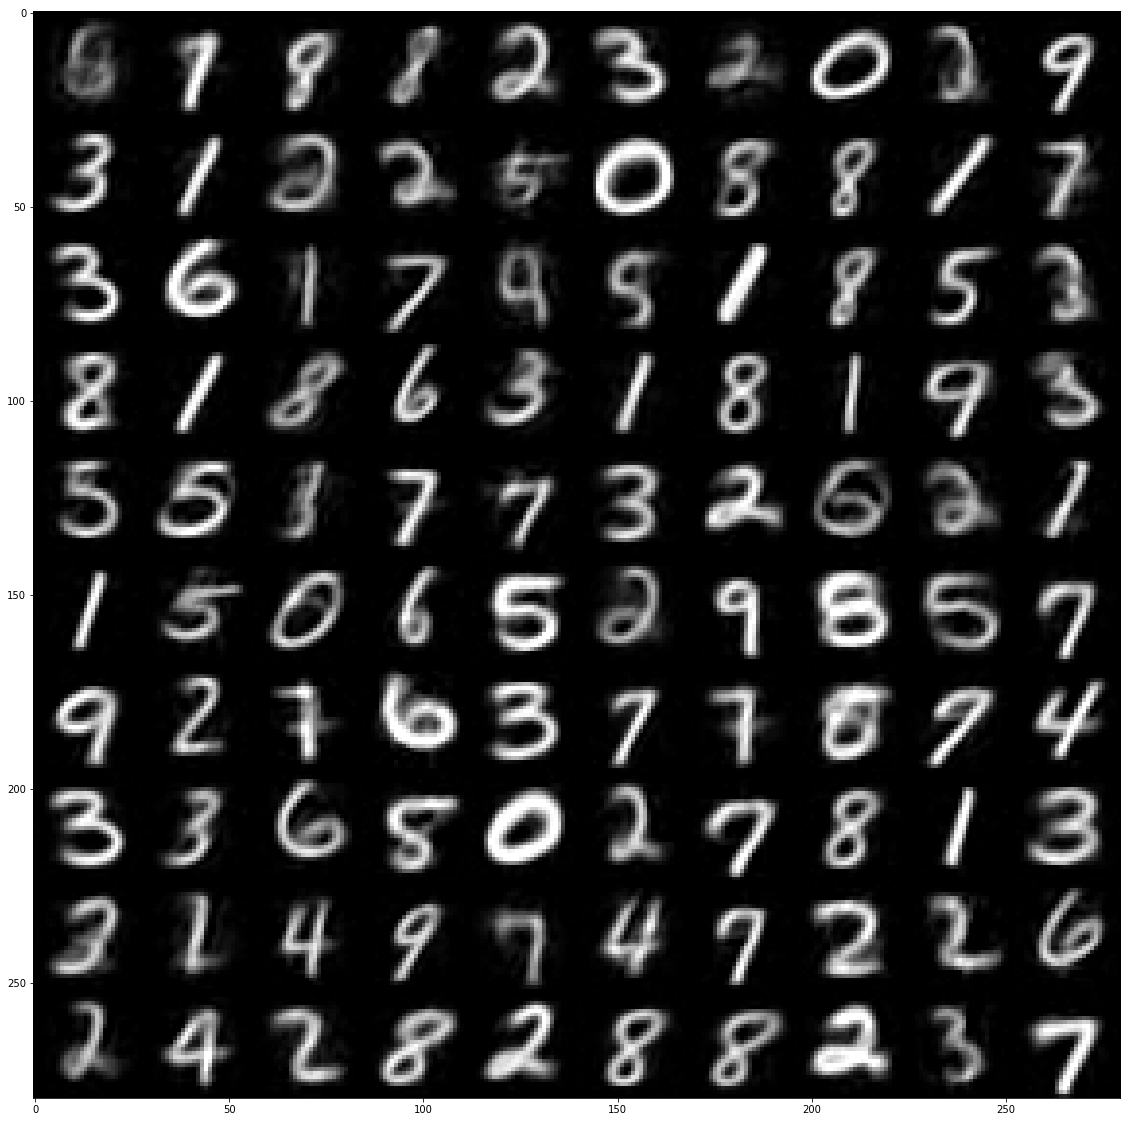

In [37]:
# train VAE
kl_divs = [] 
recon_losses = []
losses = [] 

for i in range(n_epoch):
    X = X[torch.randperm(N)]
    model.train()
    for j in range(0, N, batch_size):
        batch_x = X[j:j+batch_size]
        recon, mu, log_sigma = model(batch_x)
        loss, recon_loss, kl_div = model.loss(batch_x, recon, mu, log_sigma)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        for p,q in zip([losses, kl_divs, recon_losses], [loss, kl_div, recon_loss]):
            p.append(q.cpu().data.numpy())
    
    clear_output()
    print(i)
    plt.plot(medfilt(losses), label="loss")
    plt.legend()
    plt.show()
    
    plt.plot(medfilt(recon_losses), label="recon loss")
    plt.legend()
    plt.show()
    
    plt.plot(medfilt(kl_divs), label="kl loss")
    plt.legend()
    plt.show()
    
    num = 10
    samples = 20
    X_test_recon = utils.reconstruct(model, X_test[:samples].view(samples,-1), num)
    X_test_recon = X_test_recon.view(X_test_recon.shape[:2]+(28,28)).cpu().data.numpy()
    
    img = np.zeros((samples*28, (num+1)*28))
    for sample in range(samples):
        img[sample*28:(sample+1)*28, :28] = X_test[sample].cpu().data.numpy()
        for k in range(num):
            img[sample*28:(sample+1)*28, (k+1)*28:(k+2)*28] = X_test_recon[sample, k]
    img[img>1] = 1
    img[img<0] = 0 
    fig = plt.figure(figsize=(20,20))
    plt.imshow(img, cmap="gray")
    plt.show()
    
    
    generated = utils.generate(model, np.random.randn(100, model.z_size))
    img = np.zeros((10*28, 10*28))
    for sample in range(10):
        for k in range(10):
            img[sample*28:(sample+1)*28, (k)*28:(k+1)*28] = generated[sample*10+k].view(28,28).cpu().data.numpy()
    img[img>1] = 1
    img[img<0] = 0 
    fig = plt.figure(figsize=(20,20))
    plt.imshow(img, cmap="gray")
    plt.show()

In [38]:
model.eval()
recon, mu, log_sigma = model(X.view(-1, 784))
loss, recon_loss, kl_div =  model.loss(X.view(-1, 784), recon, mu, log_sigma)
print(loss)  
print(recon_loss)
print(kl_div)

tensor(29.8033, device='cuda:0', grad_fn=<SubBackward0>)
tensor(21.9027, device='cuda:0', grad_fn=<MulBackward0>)
tensor(-7.9006, device='cuda:0', grad_fn=<NegBackward>)


In [39]:
model.eval()
recon, mu, log_sigma = model(X_test.view(-1, 784))
loss, recon_loss, kl_div = model.loss(X_test.view(-1, 784), recon, mu, log_sigma)
print(loss)  
print(recon_loss)
print(kl_div)

tensor(30.4080, device='cuda:0', grad_fn=<SubBackward0>)
tensor(22.5648, device='cuda:0', grad_fn=<MulBackward0>)
tensor(-7.8431, device='cuda:0', grad_fn=<NegBackward>)


In [40]:
utils.save("saved_models/VAE.model", model)

In [41]:
n_epoch = 50
z_size = 16
batch_size = 64
lr  = 1e-3

model = VAE(z_size, loss_type="ce").to(device)
print(model)
optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): Sigmoid()
  )
  (loss_fn): BCELoss()
)


49


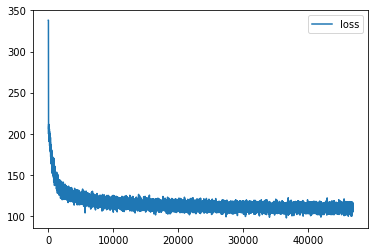

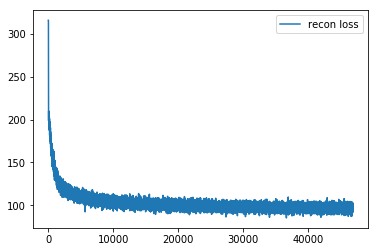

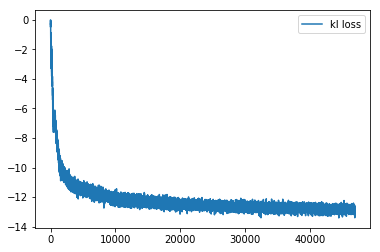

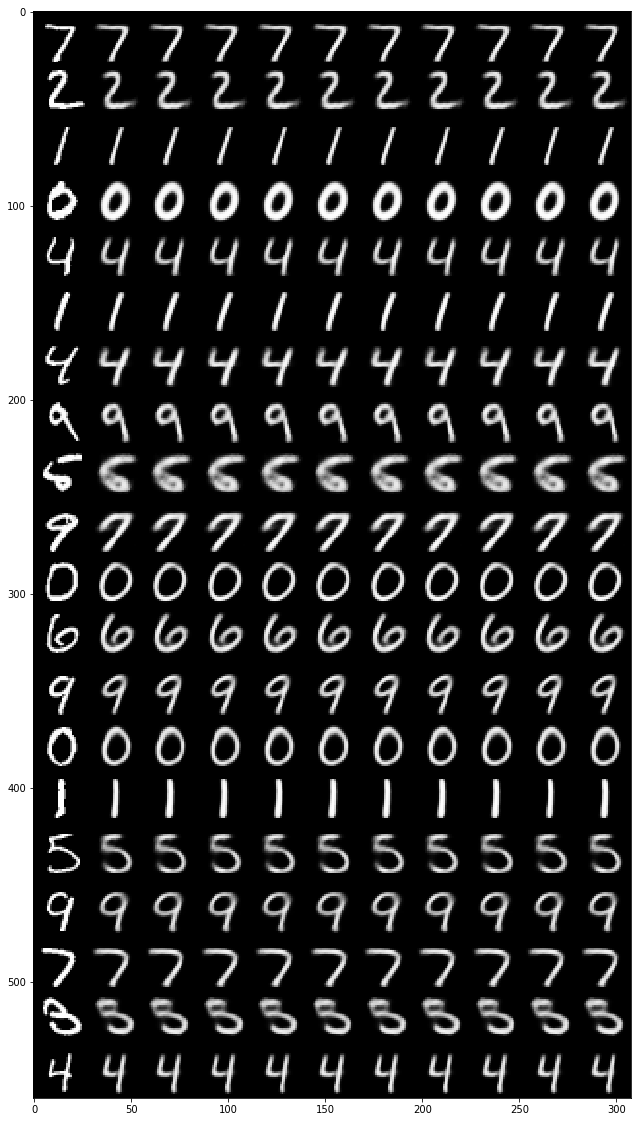

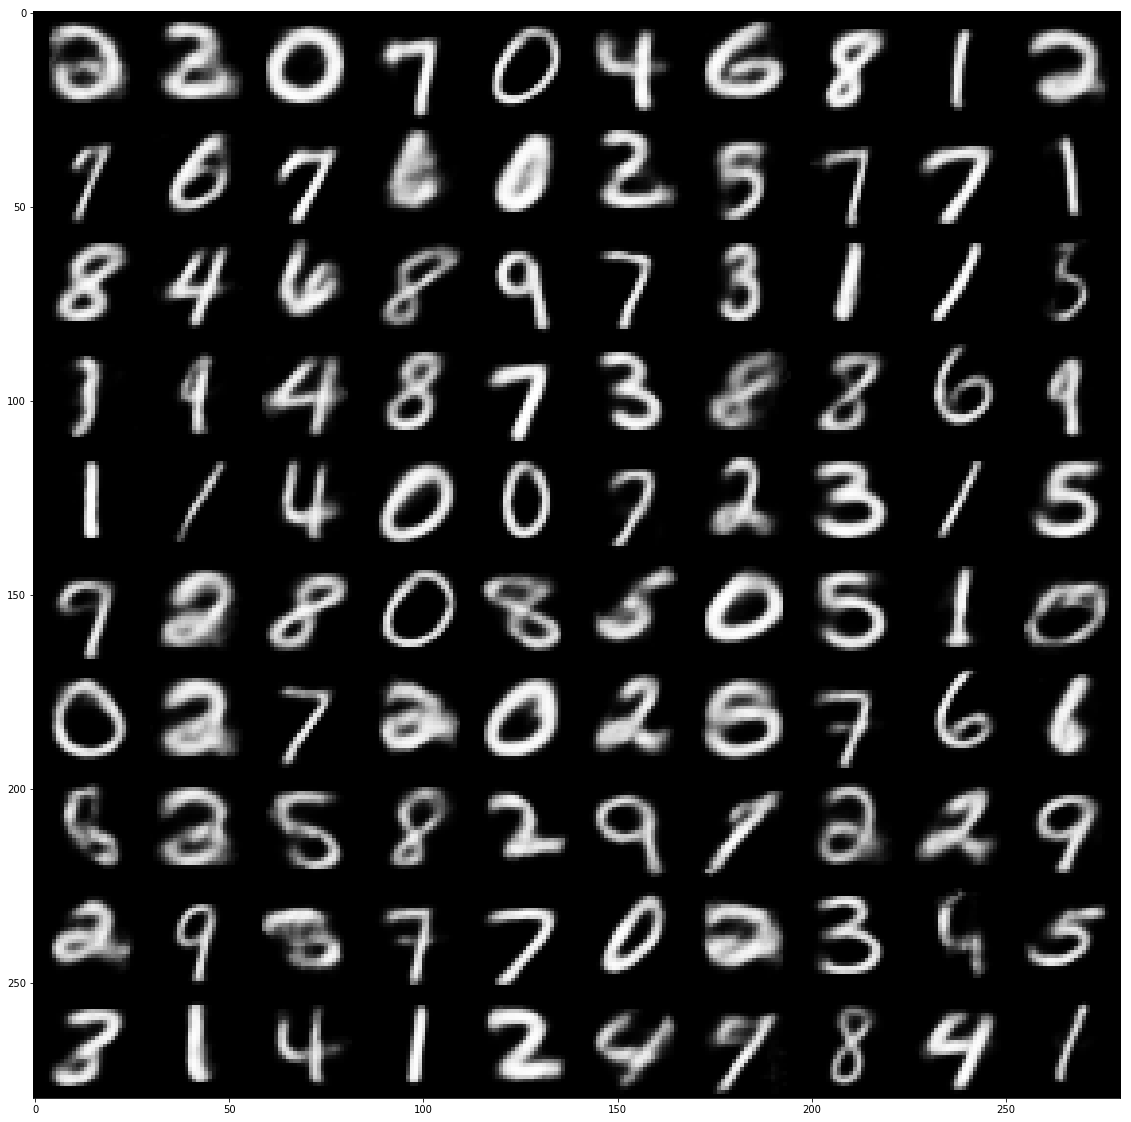

In [42]:
# train VAE
kl_divs = [] 
recon_losses = []
losses = [] 

for i in range(n_epoch):
    X = X[torch.randperm(N)]
    model.train()
    for j in range(0, N, batch_size):
        batch_x = X[j:j+batch_size]
        recon, mu, log_sigma = model(batch_x)
        loss, recon_loss, kl_div = model.loss(batch_x, recon, mu, log_sigma)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        for p,q in zip([losses, kl_divs, recon_losses], [loss, kl_div, recon_loss]):
            p.append(q.cpu().data.numpy())
    
    clear_output()
    print(i)
    plt.plot(medfilt(losses), label="loss")
    plt.legend()
    plt.show()
    
    plt.plot(medfilt(recon_losses), label="recon loss")
    plt.legend()
    plt.show()
    
    plt.plot(medfilt(kl_divs), label="kl loss")
    plt.legend()
    plt.show()
    
    num = 10
    samples = 20
    X_test_recon = utils.reconstruct(model, X_test[:samples].view(samples,-1), num)
    X_test_recon = X_test_recon.view(X_test_recon.shape[:2]+(28,28)).cpu().data.numpy()
    
    img = np.zeros((samples*28, (num+1)*28))
    for sample in range(samples):
        img[sample*28:(sample+1)*28, :28] = X_test[sample].cpu().data.numpy()
        for k in range(num):
            img[sample*28:(sample+1)*28, (k+1)*28:(k+2)*28] = X_test_recon[sample, k]
    img[img>1] = 1
    img[img<0] = 0 
    fig = plt.figure(figsize=(20,20))
    plt.imshow(img, cmap="gray")
    plt.show()
    
    
    generated = utils.generate(model, np.random.randn(100, model.z_size))
    img = np.zeros((10*28, 10*28))
    for sample in range(10):
        for k in range(10):
            img[sample*28:(sample+1)*28, (k)*28:(k+1)*28] = generated[sample*10+k].view(28,28).cpu().data.numpy()
    img[img>1] = 1
    img[img<0] = 0 
    fig = plt.figure(figsize=(20,20))
    plt.imshow(img, cmap="gray")
    plt.show()

In [43]:
model.eval()
recon, mu, log_sigma = model(X.view(-1, 784))
loss, recon_loss, kl_div =  model.loss(X.view(-1, 784), recon, mu, log_sigma)
print(loss)  
print(recon_loss)
print(kl_div)

tensor(110.4719, device='cuda:0', grad_fn=<SubBackward0>)
tensor(97.2845, device='cuda:0', grad_fn=<MulBackward0>)
tensor(-13.1873, device='cuda:0', grad_fn=<NegBackward>)


In [44]:
model.eval()
recon, mu, log_sigma = model(X_test.view(-1, 784))
loss, recon_loss, kl_div = model.loss(X_test.view(-1, 784), recon, mu, log_sigma)
print(loss)  
print(recon_loss)
print(kl_div)

tensor(114.9472, device='cuda:0', grad_fn=<SubBackward0>)
tensor(101.8543, device='cuda:0', grad_fn=<MulBackward0>)
tensor(-13.0928, device='cuda:0', grad_fn=<NegBackward>)


In [45]:
utils.save("saved_models/VAE_ce.model", model)